# Coastal change in African countries

* **Products used:** [DE Africa Coastlines]()



## Background

Coastline change can be summarised in country scale to assess trends of change. 

## Description

This notebook adds the country (level 0) and province (level 1) labels to the rate of change points.

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages
Import Python packages that are used for the analysis.

In [5]:
import geopandas as gpd
import rioxarray as rxr
import numpy as np
from shapely.ops import nearest_points

from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.coastal import get_coastlines
#from deafrica_tools.plotting import display_map
from datacube.utils.geometry import Geometry

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


## Summarise coastline changes for each admin boundaries

Calculate total kms and percentage of coastlines that has expanded or retreated by more than 0.5m per year.

In [6]:
level = 1

## Plot as figures

In [7]:
african_countries  = gpd.read_file("../../Supplementary_data/MGCI/african_countries.geojson")

In [8]:
african_countries.COUNTRY.values

array(['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
       'Burundi', 'Cameroon', 'Cape Verde', 'Central African Republic',
       'Chad', 'Comoros', 'Congo-Brazzaville', 'Cote d`Ivoire',
       'Democratic Republic of Congo', 'Djibouti', 'Egypt',
       'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia',
       'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia',
       'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Morocco',
       'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
       'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Somalia',
       'South Africa', 'Sudan', 'Swaziland', 'Tanzania', 'Togo',
       'Tunisia', 'Uganda', 'Western Sahara', 'Zambia', 'Zimbabwe'],
      dtype=object)

In [9]:
gid_coastalchange  = gpd.read_file(f"~/dev/data/coastlineschange_gadm_level{level}.gpkg")
gid_coastalchange = gid_coastalchange.fillna(0)
gid_coastalchange = gid_coastalchange.to_crs(african_countries.crs)

0.0 96.26168224299066
0.0 81.54034229828851


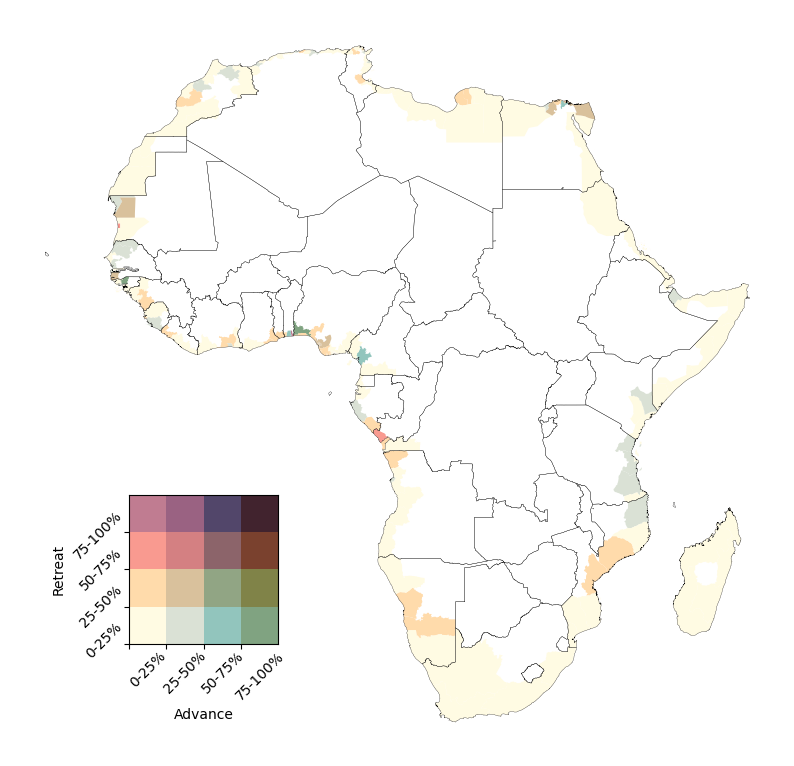

In [14]:
param_2 = 'perc_neg05'
param_1 = 'perc_pos05'

title = 'Percentage of shorelines retreating or advancing at more than 0.5 meter per year'

print(gid_coastalchange[param_1].min(), gid_coastalchange[param_1].max())
print(gid_coastalchange[param_2].min(), gid_coastalchange[param_2].max())

# Define colour map
cmap2 = mpl.cm.YlOrRd #Reds
cmap1 = mpl.cm.PuBuGn #Blues
bounds2 = [0, 20, 40, 60]
bounds1 = [0, 20, 40]

bounds1 = [0, 25, 50, 75, 100]
bounds2 = [0, 25, 50, 75, 100]

def bivariate_color(p1, p2, bounds1=bounds1, bounds2=bounds2,
                    cmap1=cmap1, cmap2=cmap2
#                    cmap1=mpl.cm.YlOrRd, cmap2=mpl.cm.PuBuGn
                   ):
    norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N)
    norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N)

    return np.sum([cmap1(norm1(p1)), cmap2(norm2(p2))], axis=0)/2.


gid_coastalchange['bivariate_color'] = list(bivariate_color(
    gid_coastalchange[param_1], gid_coastalchange[param_2]))

# Define plot and colourbar axes
fig, ax = plt.subplots(1, 1, figsize=(10, 15))

# now create inset legend
cax = ax.inset_axes([0.15, 0.15, 0.2, 0.2])
cax.set_aspect('equal', adjustable='box')
xticks=[]
yticks=[]
for ix in range(len(bounds1)-1):
    lx, hx = bounds1[ix], bounds1[ix+1]
    for iy in range(len(bounds2)-1):
        percentileboxes = [Rectangle((ix, iy), 1, 1)]
        ly, hy = bounds2[iy], bounds2[iy+1]
        pc = PatchCollection(percentileboxes,
                             facecolor=bivariate_color((lx+hx)/2, (ly+hy)/2))
        cax.add_collection(pc)
        if ix==0: yticks.append(f"{ly}-{hy}%")
    xticks.append(f"{lx}-{hx}%")

cax.set_xlim([0, len(bounds1)-1])
cax.set_ylim([0, len(bounds2)-1])
cax.tick_params("both", which="minor", length=0)
cax.set_xticks(np.arange(len(bounds1)-1), "", minor=False)
cax.set_xticks(np.arange(len(bounds1)-1)+0.5, xticks, minor=True, rotation=45)
cax.set_xlabel('Advance')
cax.set_yticks(np.arange(len(bounds2)-1), "", minor=False)
cax.set_yticks(np.arange(len(bounds2)-1)+0.5, yticks, minor=True, rotation=45)
cax.set_ylabel('Retreat')


# Turn off lon-lat ticks and labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# # Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#gid_coastalchange.plot(param, ax=ax, cmap=cmap, norm=norm);
gid_coastalchange.plot(color=gid_coastalchange['bivariate_color'], ax=ax)
#gid_1_coastalchange.geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");
#gid_0_coastalchange.simplify(0.05).geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");
african_countries.geometry.plot(
    ax=ax, linewidth=0.2, edgecolor='black', facecolor="none")


fig.savefig(f"GID_{level}_{param_1}_{param_2}.png", bbox_inches='tight')

0.0 96.26168224299066


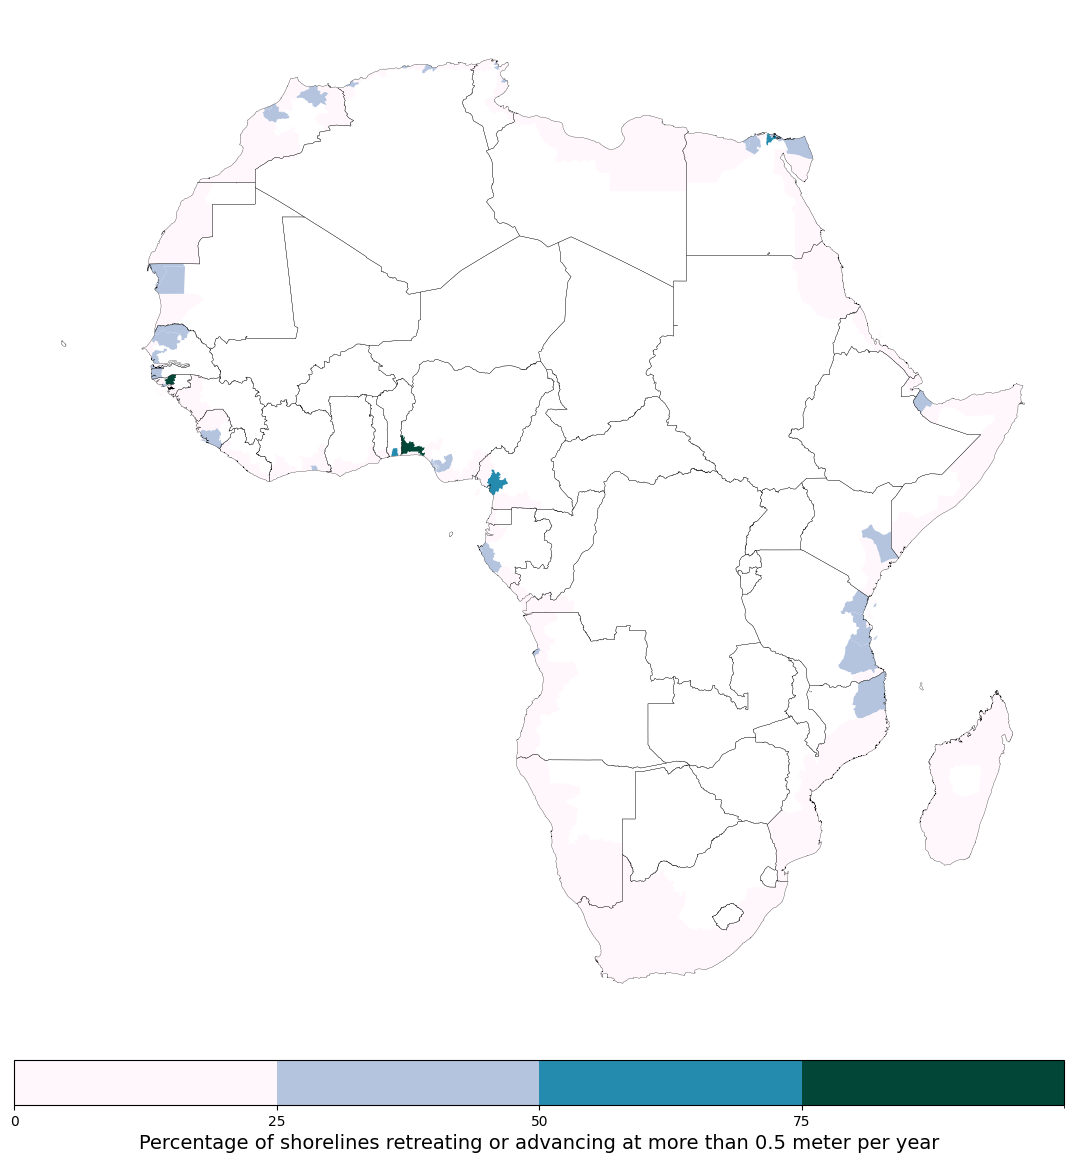

In [16]:
param = 'perc_pos05'
print(gid_coastalchange[param].min(), gid_coastalchange[param].max())

# Define plot and colourbar axes
fig, ax = plt.subplots(1,1, figsize=(15,15))
fig.subplots_adjust(bottom=0.2)
cax = fig.add_axes([0.16, 0.15, 0.70, 0.03])


# Define colour map
cmap = mpl.cm.PuBuGn
bounds = bounds1
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)#, extend='both')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

# Define colourbar labelling
# cbar.set_ticks([])
cbar.set_ticks([i for i in np.arange(bounds[0],bounds[-1],bounds[1]-bounds[0])])
cbar.set_ticklabels(list('{:.0f}'.format(i) for i in (list(np.arange(bounds[0],bounds[-1],bounds[1]-bounds[0])))))
cbar.set_label(title, fontsize='14')

# Turn off lon-lat ticks and labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# # Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

gid_coastalchange.plot(param, ax=ax, cmap=cmap, norm=norm);
#gid_1_coastalchange.geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");
#gid_0_coastalchange.simplify(0.05).geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");
african_countries.geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");



0.0 81.54034229828851


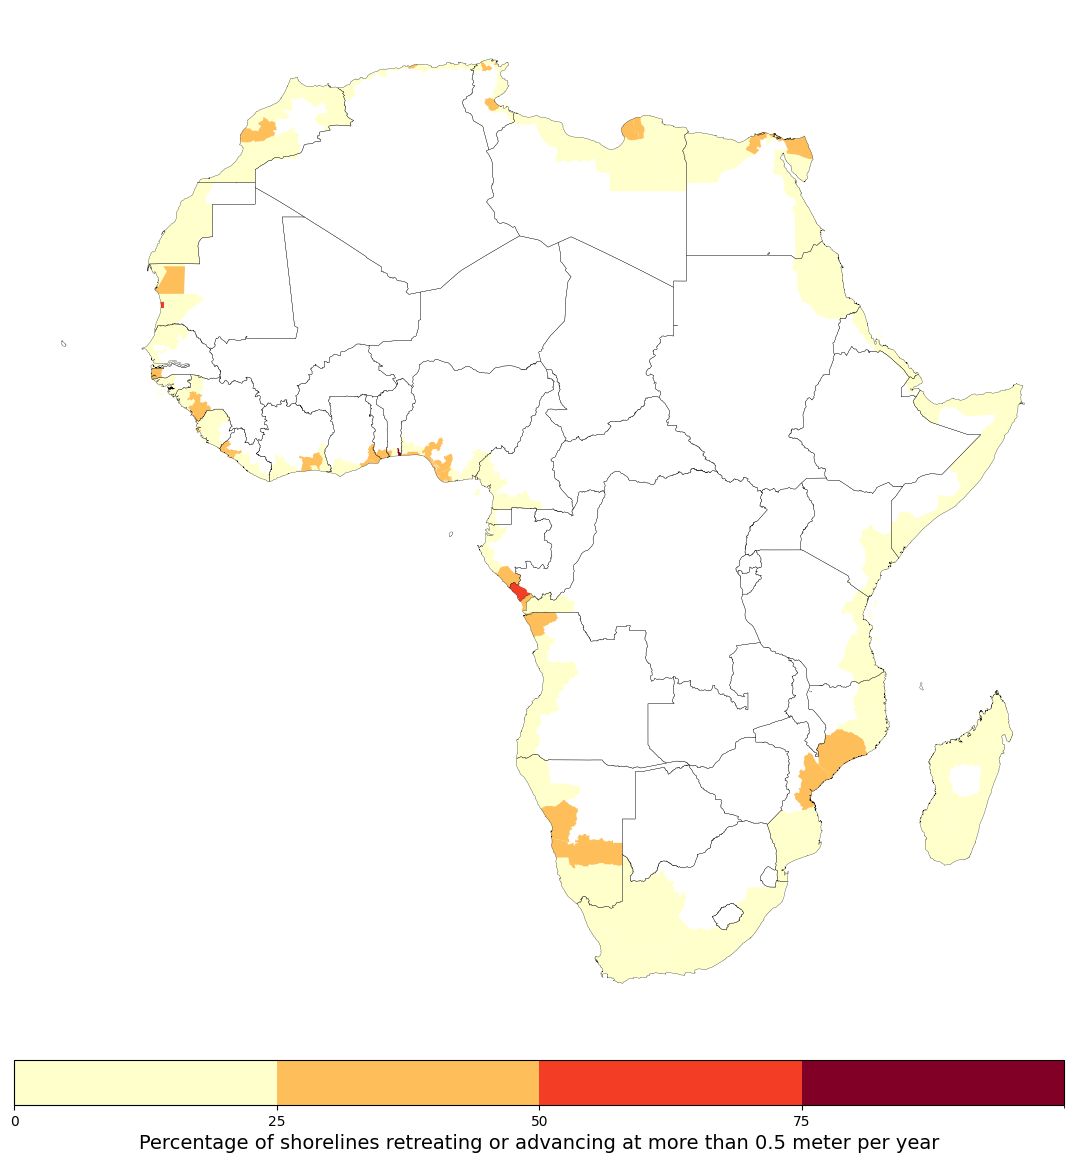

In [17]:
param = 'perc_neg05'
print(gid_coastalchange[param].min(), gid_coastalchange[param].max())

steps = np.ceil((gid_coastalchange[param].max()/10)/10)*10
#vmin, vmax = 0, np.ceil(gid_coastalchange[param].max()/steps)*steps+steps
#print(vmin, vmax)

# Define plot and colourbar axes
fig, ax = plt.subplots(1,1, figsize=(15,15))
fig.subplots_adjust(bottom=0.2)
cax = fig.add_axes([0.16, 0.15, 0.70, 0.03])


# Define colour map
cmap = mpl.cm.YlOrRd
bounds = bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)#, extend='both')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

# Define colourbar labelling
# cbar.set_ticks([])
cbar.set_ticks([i for i in np.arange(bounds[0],bounds[-1],bounds[1]-bounds[0])])
cbar.set_ticklabels(list('{:.0f}'.format(i) for i in (list(np.arange(bounds[0],bounds[-1],bounds[1]-bounds[0])))))
cbar.set_label(title, fontsize='14')

# Turn off lon-lat ticks and labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# # Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

gid_coastalchange.plot(param, ax=ax, cmap=cmap, norm=norm);
#gid_1_coastalchange.geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");
#gid_0_coastalchange.simplify(0.05).geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");
african_countries.geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");
